## Исследование данных об вторичном рынке авто

In [1287]:
pip install dateparser

Note: you may need to restart the kernel to use updated packages.


In [1288]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import numpy as np
import dateparser
import pytz
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [1289]:
#просмотрим общую информацию о датафрейме
train = pd.read_csv('Master_room1/train.csv')
test = pd.read_csv('Master_room1/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


In [1290]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


Видим что имеются пропуски в данных, так же не подходящие типы данных: дата продажи является datetime, остальные возможно необходимо изменить на категориальный тип данных, разберемся далее.

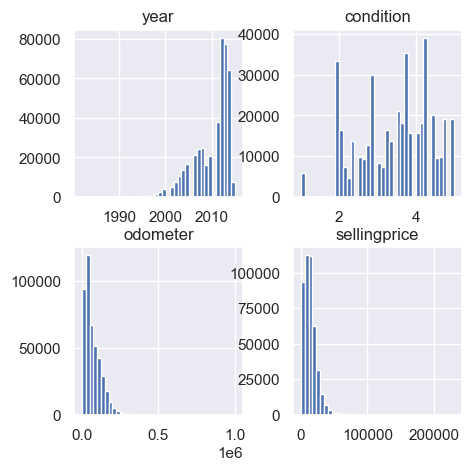

In [1291]:
#к сожалению у нас только 4 числовых столбца, поэтому это не наглядно
train.hist(figsize=(5,5), bins=40);

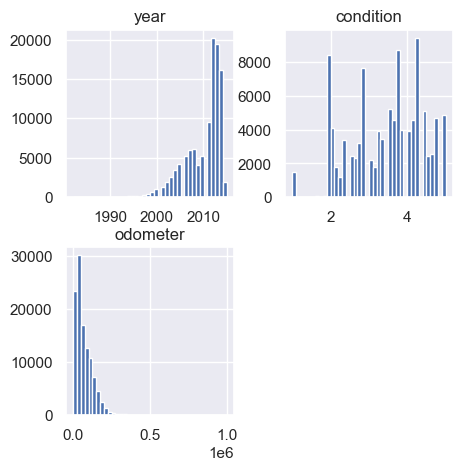

In [1292]:
test.hist(figsize=(5,5), bins=40);

    Распределение по годам, значения одометра и цена на аукционе похожи на экспоненциальное распределение.

### Предобработка данных

In [1293]:
#проверим кол-во полных дубликатов
train.duplicated().sum()

0

In [1294]:
test.duplicated().sum()

0

Проведем простую предобработку данных: уберем лишние символы в начале и конце строки, а так же все данные передем в нижний регистр.

In [1295]:
#за 1 цикл убрали и символы и перевели в нижний регистр
for i in train.select_dtypes(include='object'):
    train[i] =  train[i].str.strip('._- ')
    train[i] = train[i].str.lower()

In [1296]:
for i in train.select_dtypes(include='object'):
    test[i] =  test[i].str.strip('._- ')
    test[i] = test[i].str.lower()

#### Обработка пропусков

In [1297]:
[f'Пропущено {train[column].isna().sum()/len(train):.3f} данных в столбце {column}' for column in train.columns]

['Пропущено 0.000 данных в столбце year',
 'Пропущено 0.018 данных в столбце make',
 'Пропущено 0.018 данных в столбце model',
 'Пропущено 0.019 данных в столбце trim',
 'Пропущено 0.024 данных в столбце body',
 'Пропущено 0.117 данных в столбце transmission',
 'Пропущено 0.000 данных в столбце vin',
 'Пропущено 0.000 данных в столбце state',
 'Пропущено 0.021 данных в столбце condition',
 'Пропущено 0.000 данных в столбце odometer',
 'Пропущено 0.001 данных в столбце color',
 'Пропущено 0.001 данных в столбце interior',
 'Пропущено 0.000 данных в столбце seller',
 'Пропущено 0.000 данных в столбце sellingprice',
 'Пропущено 0.000 данных в столбце saledate']

In [1298]:
[f'Пропущено {test[column].isna().sum()/len(test):.3f} данных в столбце {column}' for column in test.columns]

['Пропущено 0.000 данных в столбце year',
 'Пропущено 0.019 данных в столбце make',
 'Пропущено 0.019 данных в столбце model',
 'Пропущено 0.019 данных в столбце trim',
 'Пропущено 0.024 данных в столбце body',
 'Пропущено 0.118 данных в столбце transmission',
 'Пропущено 0.000 данных в столбце vin',
 'Пропущено 0.000 данных в столбце state',
 'Пропущено 0.022 данных в столбце condition',
 'Пропущено 0.000 данных в столбце odometer',
 'Пропущено 0.001 данных в столбце color',
 'Пропущено 0.001 данных в столбце interior',
 'Пропущено 0.000 данных в столбце seller',
 'Пропущено 0.000 данных в столбце saledate']

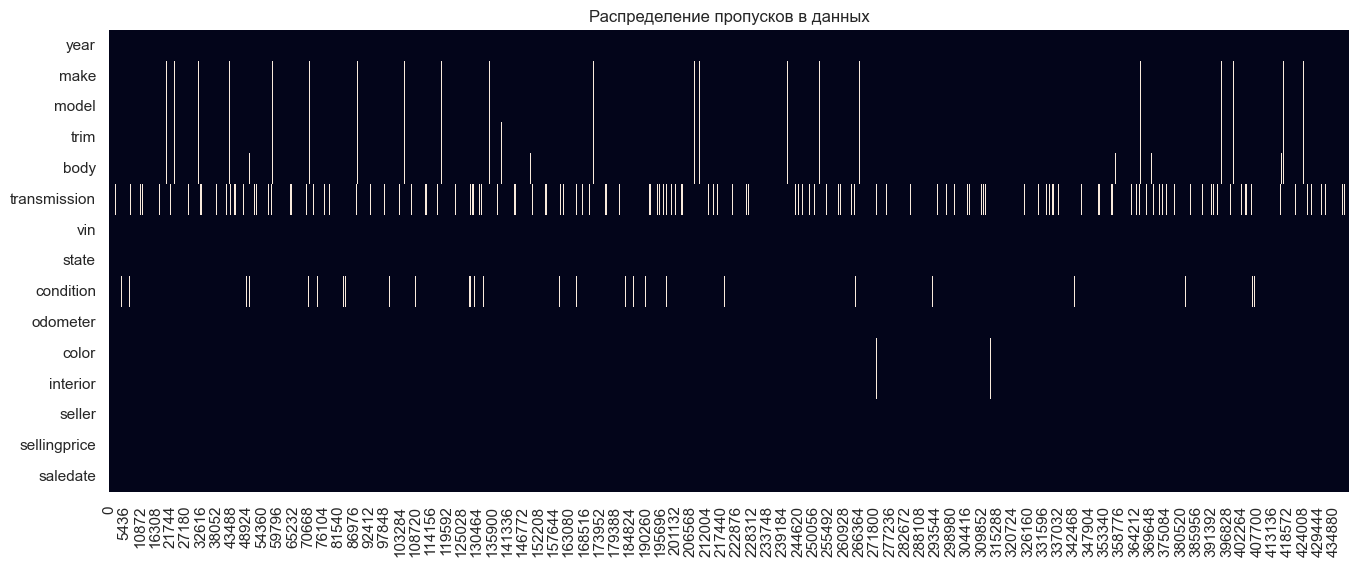

In [1299]:
sns.set(rc = {'figure.figsize':(16,6)})
#нам необходимы только пропуски (наличие или отсутствие данных), поэтому используем .isna()
#транспонируем (меняем местами столбцы со строками местами) для лучшей визуализации, испробовал разные варианты
sns.heatmap(train.isna().transpose(), cbar=False).set_title('Распределение пропусков в данных');

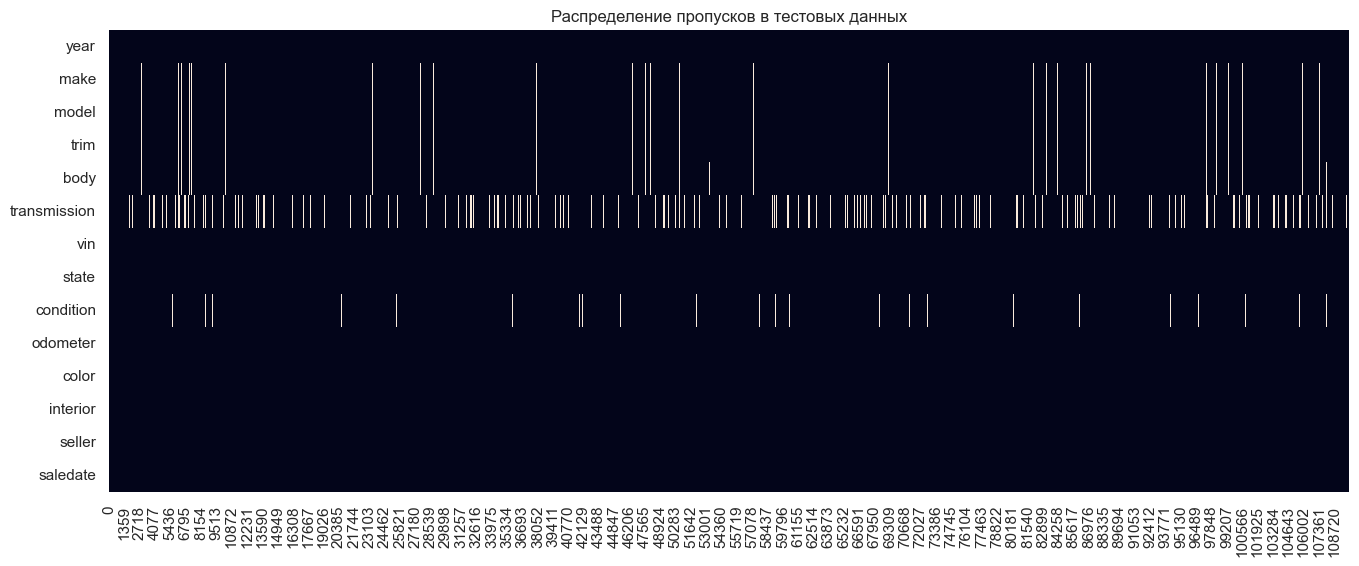

In [1300]:
sns.heatmap(test.isna().transpose(), cbar=False).set_title('Распределение пропусков в тестовых данных');

In [1301]:
train[train['make'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
10,2007,NaN,NaN,NaN,NaN,automatic,5tfbv54157x019560,ca,3.1,102507.0,blue,gray,aaero sweet company,17250,thu jan 29 2015 03:30:00 gmt-0800 (pst)
42,2007,NaN,NaN,NaN,NaN,manual,jm1bk34l671745431,md,2.8,92656.0,blue,gray,credit acceptance corp/vrs/southfield,5600,tue jun 16 2015 02:30:00 gmt-0700 (pdt)
63,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw5bda64735,ga,5.0,67159.0,white,gray,"vpsi, inc",13200,thu jun 04 2015 03:00:00 gmt-0700 (pdt)
64,2008,NaN,NaN,NaN,NaN,automatic,1gbdv13wx8d142776,ca,4.1,113582.0,white,gray,wholesale motor sales inc,4100,thu feb 05 2015 04:00:00 gmt-0800 (pst)
111,2006,NaN,NaN,NaN,NaN,automatic,3gnda13d36s611801,nv,2.8,129019.0,orange,gray,credit acceptance corp/vrs/southfield,2900,thu feb 05 2015 04:00:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440085,2011,NaN,NaN,NaN,NaN,automatic,1fdne1bw8bdb21610,az,3.5,80594.0,white,gray,mike albert fleet solutions,11100,wed feb 04 2015 03:00:00 gmt-0800 (pst)
440114,2011,NaN,NaN,NaN,NaN,automatic,2lnbl8ev9bx757689,nj,3.5,134164.0,—,black,merchants automotive group,11800,wed mar 04 2015 01:30:00 gmt-0800 (pst)
440118,2004,NaN,NaN,NaN,NaN,automatic,1gyde637240130408,md,3.5,123123.0,white,beige,credit acceptance corp/vrs/southfield,3400,tue feb 17 2015 01:30:00 gmt-0800 (pst)
440122,2007,NaN,NaN,NaN,NaN,automatic,salme15487a251642,ca,2.5,39545.0,black,black,hornburg jaguar,17750,wed jun 17 2015 05:15:00 gmt-0700 (pdt)


In [1302]:
test[test['make'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
22,2006,NaN,NaN,NaN,NaN,automatic,3gnda23d06s523147,pa,2.4,143377.0,blue,gray,ryan mtrs of morristown inc,fri jan 23 2015 01:00:00 gmt-0800 (pst)
72,2000,NaN,NaN,NaN,NaN,manual,1j4fa59s0yp723644,mo,NaN,76674.0,black,—,effingham auto care & tire inc,mon dec 22 2014 11:00:00 gmt-0800 (pst)
220,2003,NaN,NaN,NaN,NaN,automatic,jtjbt20x930014425,tx,4.9,107337.0,silver,gray,fairway ford henderson,wed feb 18 2015 02:00:00 gmt-0800 (pst)
237,1998,NaN,NaN,NaN,NaN,automatic,1j4gz78yxwc163618,nv,2.0,243163.0,gray,—,titlemax/las vegas nv32,thu feb 19 2015 03:00:00 gmt-0800 (pst)
287,2009,NaN,NaN,NaN,NaN,automatic,1gbhg39c591143468,pa,2.1,179884.0,white,gray,lease plan usa,tue feb 24 2015 01:30:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109622,2007,NaN,NaN,NaN,NaN,automatic,jm1fe173470212203,wa,2.0,133227.0,blue,beige,primus automotive financial services,wed feb 11 2015 04:35:00 gmt-0800 (pst)
109665,2010,NaN,NaN,NaN,NaN,automatic,4a32b2ff4ae011675,fl,2.9,69783.0,black,gray,premier partners inc,thu jan 15 2015 02:30:00 gmt-0800 (pst)
109717,1999,NaN,NaN,NaN,NaN,automatic,1gcdl19w1xb115016,pa,3.7,179570.0,white,blue,ari,tue feb 10 2015 01:30:00 gmt-0800 (pst)
109948,2006,NaN,NaN,NaN,NaN,automatic,2hjyk16546h509272,md,3.2,107466.0,white,beige,wells fargo dealer services,tue may 26 2015 02:30:00 gmt-0700 (pdt)


Пропуски в колонках make, model, trim полностью совпадают, эти данные можно с чистой совестью удалять.

In [1303]:
train = train.dropna(subset=['make', 'model', 'trim'])
train[train['make'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate


In [1304]:
test = test.dropna(subset=['make', 'model', 'trim'])
test[test['make'].isnull()]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate


##### Обработка make

In [1305]:
train['make'].sort_values().unique()

array(['acura', 'airstream', 'aston martin', 'audi', 'bentley', 'bmw',
       'buick', 'cadillac', 'chevrolet', 'chrysler', 'daewoo', 'dodge',
       'dodge tk', 'ferrari', 'fiat', 'fisker', 'ford', 'ford truck',
       'geo', 'gmc', 'gmc truck', 'honda', 'hummer', 'hyundai',
       'infiniti', 'isuzu', 'jaguar', 'jeep', 'kia', 'lamborghini',
       'land rover', 'landrover', 'lexus', 'lincoln', 'maserati', 'mazda',
       'mercedes', 'mercedes-b', 'mercedes-benz', 'mercury', 'mini',
       'mitsubishi', 'nissan', 'oldsmobile', 'plymouth', 'pontiac',
       'porsche', 'ram', 'rolls-royce', 'saab', 'saturn', 'scion',
       'smart', 'subaru', 'suzuki', 'tesla', 'toyota', 'volkswagen',
       'volvo', 'vw'], dtype=object)

In [1306]:
test['make'].sort_values().unique()

array(['acura', 'aston martin', 'audi', 'bentley', 'bmw', 'buick',
       'cadillac', 'chev truck', 'chevrolet', 'chrysler', 'daewoo',
       'dodge', 'ferrari', 'fiat', 'fisker', 'ford', 'ford tk', 'geo',
       'gmc', 'honda', 'hummer', 'hyundai', 'hyundai tk', 'infiniti',
       'isuzu', 'jaguar', 'jeep', 'kia', 'land rover', 'landrover',
       'lexus', 'lincoln', 'lotus', 'maserati', 'mazda', 'mercedes',
       'mercedes-benz', 'mercury', 'mini', 'mitsubishi', 'nissan',
       'oldsmobile', 'plymouth', 'pontiac', 'porsche', 'ram',
       'rolls-royce', 'saab', 'saturn', 'scion', 'smart', 'subaru',
       'suzuki', 'tesla', 'toyota', 'volkswagen', 'volvo', 'vw'],
      dtype=object)

In [1307]:
dict_make = {
    'dodge tk': 'dodge',
    'ford truck': 'ford',
    'gmc truck': 'gmc',
    'landrover': 'land rover',
    'mercedes-b': 'mercedes',
    'mercedes-benz': 'mercedes',
    'vw': 'volkswagen',
}

In [1308]:
train['make'] = train['make'].replace(dict_make)

In [1309]:
test['make'] = test['make'].replace(dict_make)

##### Обработка model

In [1310]:
train['model'].sort_values().unique()

array(['1 series', '1500', '190-class', '2 series', '200', '200sx',
       '2500', '3', '3 series', '3 series gran turismo', '300',
       '300-class', '3000gt', '300m', '300zx', '3500', '350z', '370z',
       '4 series', '4 series gran coupe', '400-class', '420-class', '42c',
       '458 italia', '4runner', '5 series', '5 series gran turismo',
       '500', '500-class', '500e', '500l', '6', '6 series',
       '6 series gran coupe', '626', '7', '7 series', '750i', '750li',
       '750lxi', '8 series', '850', '9-2x', '9-3', '9-5', '9-7x', '911',
       '940', '960', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'acadia',
       'accent', 'accord', 'accord crosstour', 'accord hybrid',
       'activehybrid 5', 'activehybrid 7', 'activehybrid x6', 'aerio',
       'alero', 'allroad', 'allroad quattro', 'alp', 'altima',
       'altima hybrid', 'amanti', 'amigo', 'armada', 'ascender', 'aspen',
       'aspire', 'astra', 'astro', 'astro cargo', 'ats', 'aura',
       'aura hybrid', 'aurora', 'avalanche', 

Значений много, явных ошибок не обнаружено.

Можно предположить что некоторые модели (например '3 series' и  '3 series gran turismo') можно привести к одному виду, т.к. мы их сможет отличть по типу кузова (седан и хэтчбек), но в реальных данных не будет '3 series' в кузове хэтчбек, только '3 series gran turismo' и мы можем пропустить такие предсказания, так что данный столбец оставляем без изменений.

##### Обработка trim

In [1311]:
train['trim'].sort_values().unique()

array(['!', '& coun fwd', '& coun fwd limited', ..., 'zx5 se', 'zx5 ses',
       'zxw ses'], dtype=object)

In [1312]:
test['trim'].sort_values().unique()

array(['!', '& coun fwd limited', '& country lx', ..., 'zx5 se',
       'zx5 ses', 'zxw ses'], dtype=object)

Видим присутствие каких-то символов в названии версии авто.

In [1313]:
train['trim'].value_counts()

trim
base                      43876
se                        34498
lx                        16511
limited                   14526
lt                        13431
                          ...  
executive pzev                1
4c base                       1
3500 sh ceiling 158 wb        1
chevy van base                1
4x4 v6 xlt sport              1
Name: count, Length: 1839, dtype: int64

Найдем все строки, которые содержат эти символы.

In [1314]:
# Поиск строк, содержащих определенные символы и двойные пробелы
result = train[train['trim'].str.contains('[!@#$%^&*()]', regex=True)]
result['trim'].value_counts()

trim
!                               368
carrera s (midyear redesign)     15
& country lx                     13
gls (1999.5)                      9
& coun fwd lx                     7
(1999.5) xe                       6
gl (1999.5)                       5
xe (1997.5)                       4
base (1999.5)                     4
gls vr6 (1999.5)                  1
& coun fwd                        1
glx vr6 (1999.5)                  1
limited (1994.5)                  1
& coun fwd limited                1
Name: count, dtype: int64

In [1315]:
# Поиск строк, содержащих определенные символы и двойные пробелы
result1 = test[test['trim'].str.contains('[!@#$%^&*()]', regex=True)]
result1['trim'].value_counts()

trim
!                               83
gls (1999.5)                     8
carrera s (midyear redesign)     6
base (1999.5)                    4
xe (1997.5)                      3
& country lx                     2
& coun fwd limited               2
(1999.5) xe                      1
gl (1999.5)                      1
limited (1994.5)                 1
glx vr6 (1999.5)                 1
Name: count, dtype: int64

In [1316]:
result[result['trim']=='!'].sort_values(by='make')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
114,2010,kia,soul,!,wagon,automatic,kndjt2a28a7133671,fl,3.6,49074.0,green,black,remarketing by ge/space coast credit union,9500,wed jan 21 2015 01:00:00 gmt-0800 (pst)
291405,2011,kia,soul,!,wagon,automatic,kndjt2a27b7224643,fl,3.7,93430.0,black,black,santander consumer,8900,thu jan 29 2015 01:35:00 gmt-0800 (pst)
290250,2010,kia,soul,!,wagon,NaN,kndjt2a26a7038879,md,1.9,91813.0,white,black,capital one auto finance,5000,tue jan 13 2015 09:30:00 gmt-0800 (pst)
287154,2011,kia,soul,!,wagon,automatic,kndjt2a29b7275917,ga,2.4,56004.0,orange,black,wells fargo dealer services,7700,thu dec 18 2014 10:00:00 gmt-0800 (pst)
287109,2010,kia,soul,!,wagon,manual,kndjt2a27a7037272,ga,2.9,116744.0,white,black,nalley kia,6300,tue feb 03 2015 05:00:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126920,2011,kia,soul,!,wagon,NaN,kndjt2a2xb7289499,ns,4.6,151441.0,orange,gray,tantramar chevrolet buick gmc (2009) ltd,6800,wed may 27 2015 01:30:00 gmt-0700 (pdt)
126806,2010,kia,soul,!,wagon,NaN,kndjt2a21a7045593,ny,2.1,114688.0,green,black,fleet lease disposal,4450,wed jan 07 2015 09:30:00 gmt-0800 (pst)
125189,2011,kia,soul,!,wagon,automatic,kndjt2a23b7242332,ca,3.3,70790.0,black,black,mas financial services,8500,wed feb 11 2015 04:05:00 gmt-0800 (pst)
138450,2010,kia,soul,!,wagon,automatic,kndjt2a20a7702464,ca,2.1,99273.0,white,black,first investors servicing corp,7300,tue dec 16 2014 12:30:00 gmt-0800 (pst)


In [1317]:
result[(result['make']=='kia') & (result['model']=='soul')].sort_values(by='trim')

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
114,2010,kia,soul,!,wagon,automatic,kndjt2a28a7133671,fl,3.6,49074.0,green,black,remarketing by ge/space coast credit union,9500,wed jan 21 2015 01:00:00 gmt-0800 (pst)
291405,2011,kia,soul,!,wagon,automatic,kndjt2a27b7224643,fl,3.7,93430.0,black,black,santander consumer,8900,thu jan 29 2015 01:35:00 gmt-0800 (pst)
290250,2010,kia,soul,!,wagon,NaN,kndjt2a26a7038879,md,1.9,91813.0,white,black,capital one auto finance,5000,tue jan 13 2015 09:30:00 gmt-0800 (pst)
287154,2011,kia,soul,!,wagon,automatic,kndjt2a29b7275917,ga,2.4,56004.0,orange,black,wells fargo dealer services,7700,thu dec 18 2014 10:00:00 gmt-0800 (pst)
287109,2010,kia,soul,!,wagon,manual,kndjt2a27a7037272,ga,2.9,116744.0,white,black,nalley kia,6300,tue feb 03 2015 05:00:00 gmt-0800 (pst)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126920,2011,kia,soul,!,wagon,NaN,kndjt2a2xb7289499,ns,4.6,151441.0,orange,gray,tantramar chevrolet buick gmc (2009) ltd,6800,wed may 27 2015 01:30:00 gmt-0700 (pdt)
126806,2010,kia,soul,!,wagon,NaN,kndjt2a21a7045593,ny,2.1,114688.0,green,black,fleet lease disposal,4450,wed jan 07 2015 09:30:00 gmt-0800 (pst)
125189,2011,kia,soul,!,wagon,automatic,kndjt2a23b7242332,ca,3.3,70790.0,black,black,mas financial services,8500,wed feb 11 2015 04:05:00 gmt-0800 (pst)
138450,2010,kia,soul,!,wagon,automatic,kndjt2a20a7702464,ca,2.1,99273.0,white,black,first investors servicing corp,7300,tue dec 16 2014 12:30:00 gmt-0800 (pst)


Погуглив и погрузившись в мир моделей авто, стало ясно, что ошибки тут в сроках содержащих "coun" вместо "country".
При этом "!" хоть и является ошибкой, но эти значения содержат одна и та же модель и НИКАКИХ других значений в колонке "trim" нет, видимо так заполняли отсутствие значения именно для этой модели.
Заменим на значение "unknown", т.к. будущие модели могут некорректно воспринять этот символ.

In [1318]:
train['trim'] = train['trim'].replace('!', 'unknown')

In [1319]:
test['trim'] = test['trim'].replace('!', 'unknown')

##### Обработка body

In [1320]:
train['body'].isnull().sum()

2056

In [1321]:
test['body'].isnull().sum()

480

In [1322]:
train['body'].sort_values().unique()

array(['access cab', 'beetle convertible', 'cab plus', 'cab plus 4',
       'club cab', 'convertible', 'coupe', 'crew cab', 'crewmax cab',
       'cts coupe', 'cts wagon', 'cts-v coupe', 'cts-v wagon',
       'double cab', 'e-series van', 'elantra coupe', 'extended cab',
       'g convertible', 'g coupe', 'g sedan', 'g37 convertible',
       'g37 coupe', 'genesis coupe', 'granturismo convertible',
       'hatchback', 'king cab', 'koup', 'mega cab', 'minivan',
       'promaster cargo van', 'q60 convertible', 'q60 coupe', 'quad cab',
       'ram van', 'regular cab', 'regular-cab', 'sedan', 'supercab',
       'supercrew', 'suv', 'transit van', 'tsx sport wagon', 'van',
       'wagon', 'xtracab', nan], dtype=object)

In [1323]:
test['body'].sort_values().unique()

array(['access cab', 'beetle convertible', 'cab plus', 'club cab',
       'convertible', 'coupe', 'crew cab', 'crewmax cab', 'cts coupe',
       'cts wagon', 'cts-v coupe', 'double cab', 'e-series van',
       'elantra coupe', 'extended cab', 'g convertible', 'g coupe',
       'g sedan', 'g37 convertible', 'g37 coupe', 'genesis coupe',
       'granturismo convertible', 'hatchback', 'king cab', 'koup',
       'mega cab', 'minivan', 'promaster cargo van', 'q60 convertible',
       'q60 coupe', 'quad cab', 'regular cab', 'regular-cab', 'sedan',
       'supercab', 'supercrew', 'suv', 'transit van', 'tsx sport wagon',
       'van', 'wagon', 'xtracab', nan], dtype=object)

In [1324]:
train['body'].value_counts().head(80)

body
sedan                      190781
suv                        113042
hatchback                   20715
minivan                     20114
coupe                       13896
crew cab                    12823
wagon                       12600
convertible                  8183
supercrew                    7081
g sedan                      5859
supercab                     4143
regular cab                  3861
van                          3544
extended cab                 3500
quad cab                     3208
e-series van                 1426
g coupe                      1282
double cab                   1260
crewmax cab                   429
king cab                      418
g convertible                 251
access cab                    232
genesis coupe                 221
club cab                      141
koup                          135
cts coupe                     115
mega cab                       94
elantra coupe                  74
beetle convertible             52
promaster

In [1325]:
test['body'].value_counts().head(80)

body
sedan                      47466
suv                        28295
hatchback                   5152
minivan                     5091
coupe                       3503
wagon                       3276
crew cab                    3152
convertible                 2059
supercrew                   1731
g sedan                     1486
supercab                    1045
extended cab                 922
van                          919
regular cab                  918
quad cab                     795
e-series van                 387
double cab                   306
g coupe                      299
crewmax cab                  117
king cab                      95
g convertible                 69
genesis coupe                 68
access cab                    54
koup                          43
cts coupe                     38
club cab                      35
elantra coupe                 29
mega cab                      17
promaster cargo van           14
xtracab                       11
q60 c

In [1326]:
#создадим словарь с неправильными названиям, где кол-во > 10 (просто так захотелось)
dict_body = {'g convertible': 'convertible',
'q60 convertible': 'convertible',
'g37 convertible': 'convertible',
'beetle convertible': 'convertible',
'granturismo convertible': 'convertible',
'g sedan': 'sedan',
'g coupe': 'coupe',
'q60 coupe': 'coupe',
'genesis coupe': 'coupe',
'elantra coupe': 'coupe',
'cts coupe': 'coupe',
'koup': 'coupe',
'g37 coupe': 'coupe',
'promaster cargo van': 'van',
'transit van': 'van',
'tsx sport wagon': 'wagon',
            }

In [1327]:
#заменим эти значения
train['body'] = train['body'].replace(dict_body)

In [1328]:
test['body'] = test['body'].replace(dict_body)

In [1329]:
#удалим строки, где содержится меньше 10-ти типов кузовов (редкие авто, можно считать за выбросы)
counts_body = train['body'].value_counts()
body_counts_less_than_10 = counts_body[counts_body < 10].index
train = train[~train['body'].isin(body_counts_less_than_10)]

In [1330]:
counts_body1 = test['body'].value_counts()
body_counts_less_than_10_1 = counts_body1[counts_body1 < 10].index
test = test[~test['body'].isin(body_counts_less_than_10_1)]

Пропуски можно заполнить самыми часто встречающимися значениями (модой) в колонках "make" + "model".

In [1331]:
train['body'] = train.groupby(['make', 'model'])['body'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1332]:
test['body'] = test.groupby(['make', 'model'])['body'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1333]:
#проверим кол-во пропусков и удалим их
train['body'].isnull().sum()

742

In [1334]:
test['body'].isnull().sum()

170

In [1335]:
train = train.dropna(subset=['body'])

In [1336]:
test = test.dropna(subset=['body'])

##### Обработка transmission

In [1337]:
train['transmission'].value_counts()

transmission
automatic    367912
manual        13230
Name: count, dtype: int64

In [1338]:
test['transmission'].value_counts()

transmission
automatic    91771
manual        3344
Name: count, dtype: int64

In [1339]:
train['transmission'].isnull().sum()

49915

In [1340]:
test['transmission'].isnull().sum()

12626

Аналогично заменим пропуски в данном столбце самыми часто встречающимися значениями

In [1341]:
train['transmission'] = train.groupby(['make', 'model'])['transmission'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1342]:
test['transmission'] = test.groupby(['make', 'model'])['transmission'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1343]:
train['transmission'].isnull().sum()

4

In [1344]:
test['transmission'].isnull().sum()

10

In [1345]:
#удалим эти строки
train = train.dropna(subset=['transmission'])

In [1346]:
test = test.dropna(subset=['transmission'])

##### Обработка vin

Длина vin номера всегда равняется 17 знакам, проверим, сущесвуют ли аномалии по кол-ву символов.

In [1347]:
# Создаем столбец с длиной текстового значения
train['vin_length'] = train['vin'].apply(len)

# Поиск аномалий
train[train['vin_length']!=17]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,vin_length


In [1348]:
# Создаем столбец с длиной текстового значения
test['vin_length'] = test['vin'].apply(len)

# Поиск аномалий
test[test['vin_length']!=17]

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,vin_length


In [1349]:
#удалим лишний столбец
del train['vin_length']

In [1350]:
del test['vin_length']

Проверим на дубликаты

In [1351]:
train['vin'].duplicated().sum()

0

In [1352]:
test['vin'].duplicated().sum()

0

##### Обработка state

In [1353]:
train['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

In [1354]:
test['state'].sort_values().unique()

array(['ab', 'al', 'az', 'ca', 'co', 'fl', 'ga', 'hi', 'il', 'in', 'la',
       'ma', 'md', 'mi', 'mn', 'mo', 'ms', 'nc', 'ne', 'nj', 'nm', 'ns',
       'nv', 'ny', 'oh', 'ok', 'on', 'or', 'pa', 'pr', 'qc', 'sc', 'tn',
       'tx', 'ut', 'va', 'wa', 'wi'], dtype=object)

Вроде всё в порядке.

##### Обработка condition

In [1355]:
train['condition'].sort_values().unique()

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
       2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
       3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
       4.9, 5. , nan])

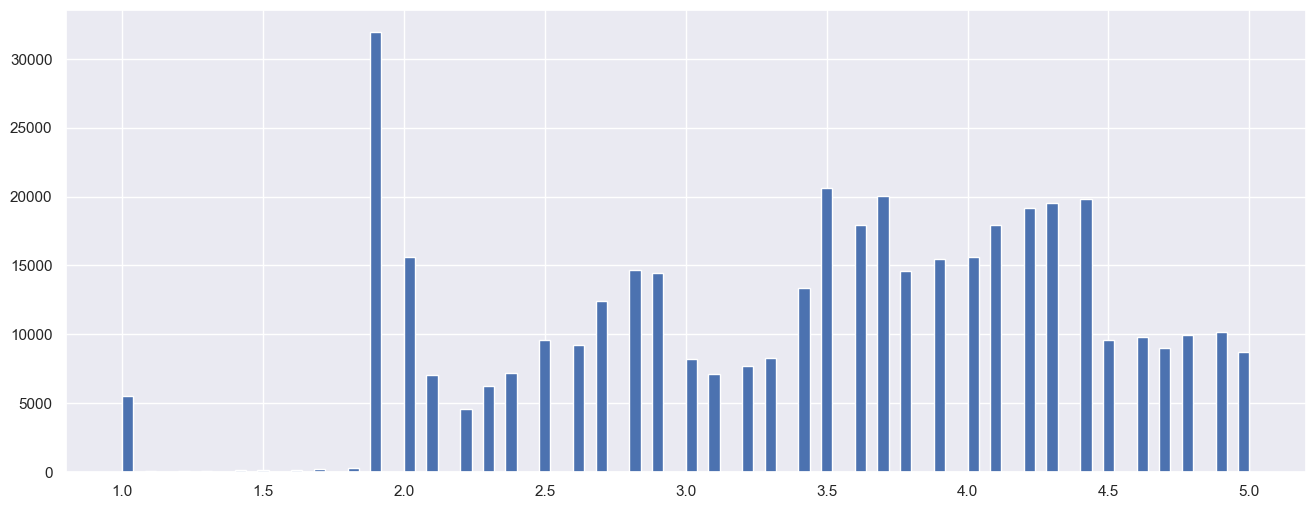

In [1356]:
train['condition'].hist(bins=100);

Между 1 и примерно 1.8 практически нет данных, но при этом есть пик на 1.9 это возможно объяснить человеческим фактором: плохие машины хочется оценить чуть лучше, чтобы продать дороже, ИЛИ сложно оценить авто на эти баллы, поэтому ставили "двоечку". Необходимо проверить, есть ли связь между этой оценкой и какими-нибудь параметрами: годом, пробегом или возможно ПРОДАВЦОМ (вдруг на наших глазах творится афера.)
Аномалий нет, но есть пропуски.

In [1357]:
train['condition'].isna().sum()

9165

In [1358]:
test['condition'].isna().sum()

2316

In [1359]:
#заполним пропуски самым частым значением года и модели, т.к. скорее всего эти машины эксплуатировались в схожих условиях 
# + 'CONDITION' является категориальным значением
train['condition'] = train.groupby(['year', 'model'])['condition'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1360]:
test['condition'] = test.groupby(['year', 'model'])['condition'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1361]:
train['condition'].isna().sum()

35

In [1362]:
test['condition'].isna().sum()

39

In [1363]:
#удалим пропуски
train = train.dropna(subset=['condition'])

In [1364]:
test = test.dropna(subset=['condition'])

##### Обработка odometer

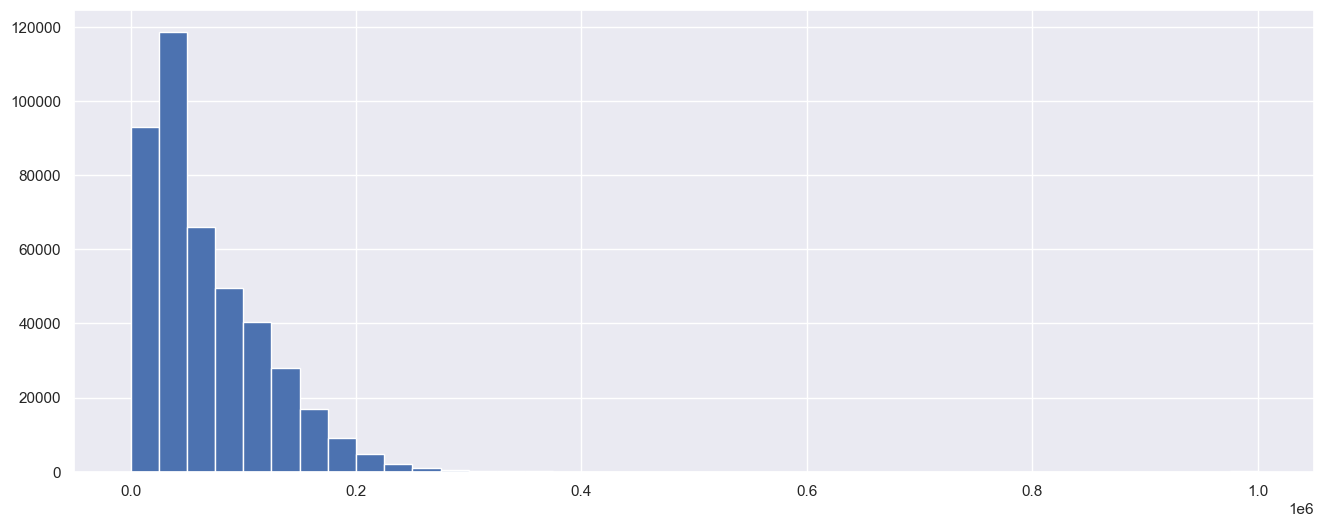

In [1365]:
train['odometer'].hist(bins=40);

Значения больше 0.3*1e6 являются выбросами, их можно удалить.

In [1366]:
train[train['odometer']>0.3*1e6].shape[0]

534

In [1367]:
test[test['odometer']>0.3*1e6].shape[0]

137

In [1368]:
train = train[~(train['odometer']>0.3*1e6)]

In [1369]:
train.dropna(subset=['odometer'], inplace=True)

In [1370]:
test = test[~(test['odometer']>0.3*1e6)]

In [1371]:
test.dropna(subset=['odometer'], inplace=True)

##### Обработка color

In [1372]:
train['color'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

In [1373]:
test['color'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'charcoal', 'gold',
       'gray', 'green', 'lime', 'off-white', 'orange', 'pink', 'purple',
       'red', 'silver', 'turquoise', 'white', 'yellow', '—', nan],
      dtype=object)

Неправильно названных цветов нет, но есть "-" и пропуски, чтобы обработать необходимо:

1) заменить "-" на пропуск
2) заменить пропуск на моду (т.к. цвета это категориальный признак)

In [1374]:
train['color'] = train['color'].replace('—', np.nan)

In [1375]:
test['color'] = test['color'].replace('—', np.nan)

Цвет машины может коррелировать с маркой и моделью авто, т.к.некоторые авто могут поставляться с ограниченным набором цветов.

In [1376]:
train['color'] = train.groupby(['make', 'model'])['color'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1377]:
test['color'] = test.groupby(['make', 'model'])['color'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1378]:
train['color'].isna().sum()

1

In [1379]:
test['color'].isna().sum()

1

In [1380]:
train = train.dropna(subset=['color'])

In [1381]:
test = test.dropna(subset=['color'])

##### Обработка interior

In [1382]:
train['interior'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

In [1383]:
test['interior'].sort_values().unique()

array(['beige', 'black', 'blue', 'brown', 'burgundy', 'gold', 'gray',
       'green', 'off-white', 'orange', 'purple', 'red', 'silver', 'tan',
       'white', 'yellow', '—', nan], dtype=object)

Аналогично цвету кузова.

In [1384]:
train['interior'] = train['interior'].replace('—', np.nan)

In [1385]:
test['interior'] = test['interior'].replace('—', np.nan)

In [1386]:
train['interior'] = train.groupby(['make', 'model'])['interior'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1387]:
test['interior'] = test.groupby(['make', 'model'])['interior'].transform(lambda x: x.fillna(x.mode().iat[0]) if x.mode().size > 0 else x)

In [1388]:
train['interior'].isna().sum()

2

In [1389]:
test['interior'].isna().sum()

1

In [1390]:
train = train.dropna(subset=['interior'])

In [1391]:
test = test.dropna(subset=['interior'])

##### Обработка seller

In [1392]:
train['seller'].value_counts()

seller
nissan-infiniti lt               15823
ford motor credit company,llc    15256
the hertz corporation            14669
santander consumer               11988
avis corporation                 10091
                                 ...  
lextechs of atlanta                  1
graff chevrolet company              1
g's automotive                       1
love auto group inc                  1
studio city auto group               1
Name: count, Length: 12803, dtype: int64

Возможно имеются опечатки в названиях продацавцов, но данных слишком много для ручного поиска.
Если результаты будут плохими - возможно нужно будет группировать на частные и корпоративные по ключевым словам(company, corporation, ltd и т.п.)

##### Обработка sellingprice

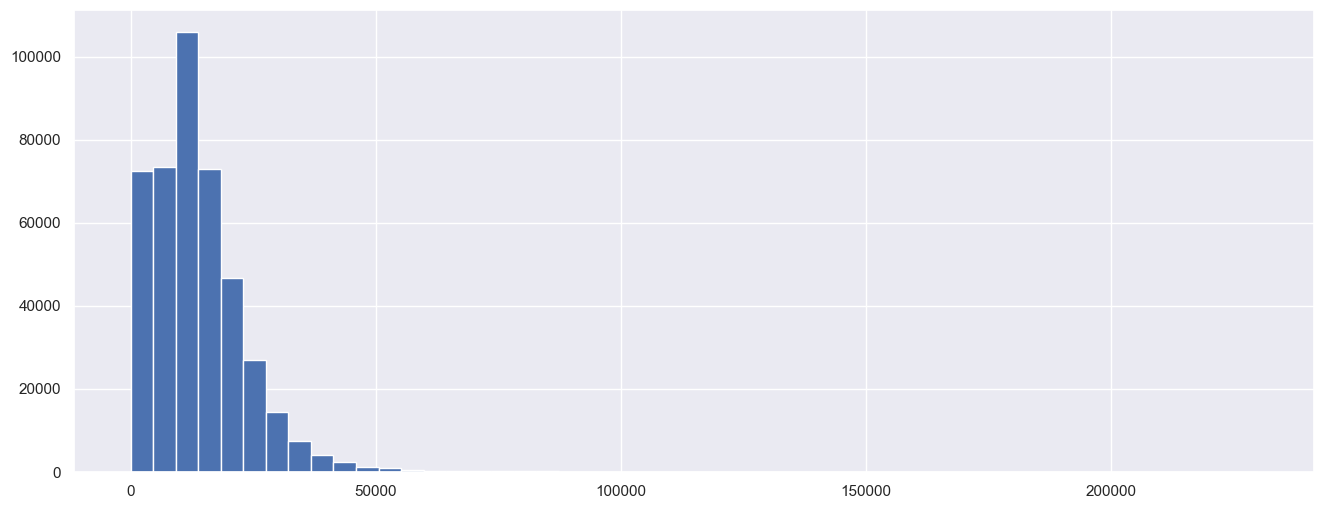

In [1393]:
train['sellingprice'].hist(bins=50);

In [1394]:
train[train['sellingprice']>100000].shape[0]

133

Удалим машины стоимостью выше 60000, т.к. их кол-во мало, относительно общей массы: 0.0003% и 0.001% для тренировочной и тестовыъ выборок соответственно, люкс авто - по индивидуальной цене, пожалуйста))

In [1395]:
train = train[train['sellingprice']<100000]

##### Обработка saledate

In [1396]:
train['saledate'].head(5)

0    tue jun 02 2015 02:30:00 gmt-0700 (pdt)
1    wed feb 25 2015 02:00:00 gmt-0800 (pst)
2    wed jun 10 2015 02:30:00 gmt-0700 (pdt)
3    wed jun 17 2015 03:00:00 gmt-0700 (pdt)
4    tue feb 03 2015 04:00:00 gmt-0800 (pst)
Name: saledate, dtype: object

Данные имеют тип object  и не могут быть интерпретированы через встроенные библиотеки, поэтому применяем dateparser.

Возможно вытащить данные из столбца, т.к. данные имеют четкую структуру, но не хочется заморачиваться.

In [1397]:
train['saledate'] = train['saledate'].apply(lambda x: dateparser.parse(x.split('(')[0].strip()))

In [1398]:
test['saledate'] = test['saledate'].apply(lambda x: dateparser.parse(x.split('(')[0].strip()))

In [1399]:
train['saledate'] = pd.to_datetime(train['saledate'], utc=True)

In [1400]:
test['saledate'] = pd.to_datetime(test['saledate'], utc=True)

In [1401]:
train['sale_year'] = train['saledate'].dt.year
train['sale_month'] = train['saledate'].dt.month
train['sale_day'] = train['saledate'].dt.day
train['sale_weekday'] = train['saledate'].dt.weekday
train['sale_hour'] = train['saledate'].dt.hour
del train['saledate']

In [1402]:
test['sale_year'] = test['saledate'].dt.year
test['sale_month'] = test['saledate'].dt.month
test['sale_day'] = test['saledate'].dt.day
test['sale_weekday'] = test['saledate'].dt.weekday
test['sale_hour'] = test['saledate'].dt.hour

In [1403]:
del test['saledate']

#### Выводы к ОБРАБОТКА ПРОПУСКОВ

Удалено около 2.5% данных, которые было сложно(возможно вообще?) обработать.
Пропуски замещены самыми частыми значениями в своих группах (модой), т.к. являются категориальными признаками.

#### Преобразование типов данных

Преобразуем типы данных в подходящие, чтобы ускорить и улучшить работу будущих моделей.

##### Преобразование типов object

In [1404]:
#Типы данных имеющие типы данных object изменим на категориальный тип дынных
for column in train.columns:
    if train[column].dtype == 'object':
        train[column] = train[column].astype('category')

In [1405]:
for column in test.columns:
    if test[column].dtype == 'object':
        test[column] = test[column].astype('category')

##### Добавляем столбец возраст

Сам по себе год производства нам не нужен, нам нужна разница между годом его производство и датой его продажи, т.е. узнать "возраст". Поэтому из двух колонок можно сделать одну.

In [1406]:
train['age'] = train['sale_year'] - train['year']

In [1407]:
test['age'] = test['sale_year'] - test['year']

<Axes: xlabel='age', ylabel='odometer'>

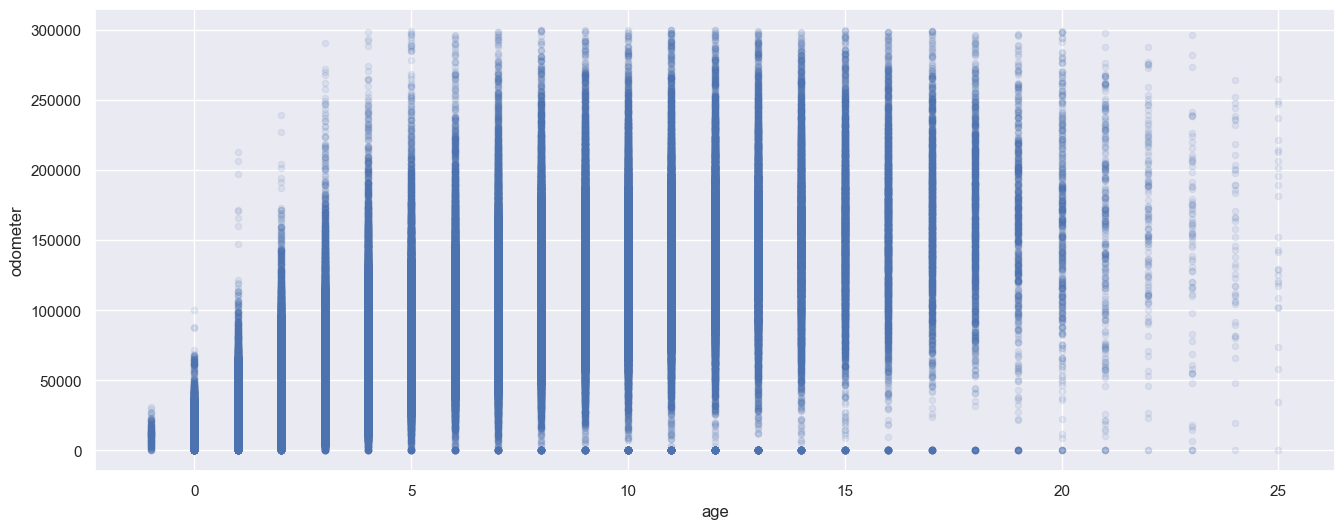

In [1408]:
train.plot(x='age', y='odometer', kind='scatter', alpha=0.1) 

Видим что есть авто с отрицальным возрастом, можно предположить что dateparse сработал некорректно, или что авто были и куплены по предоплате, т.е. сделка заключена ранее, чем был произведен автомобиль, но в таком случае возраст авто будет равняться 0 годам, 0 месяцам и т.д.
Т.к. задача состоит в предсказании стоимости авто на ВТОРИЧНОМ рынке, то это можно считать выбросами. Узнаем кол-во таких авто.

In [1409]:
#авто с отрицательным возрастом
train[train['age']==-1].shape[0]

166

In [1410]:
test[test['age']==-1].shape[0]

35

In [1411]:
#удаляем строки где возраст отрицателен
train = train[train['age']!=-1]

In [1412]:
test = test[test['age']!=-1]

In [1413]:
#теперь столбцы year и sale_year нам не нужны
del train['year']
del test['year']

In [1414]:
del train['sale_year']
del test['sale_year']

##### Преобразование seller

Изменим продавца на категории, зависящей от кол-ва продаж.

In [1415]:
seller_counts = train['seller'].value_counts()
bins = [0, 10, 100, 1000, float('inf')]  # Границы для категорий
labels = ['Low', 'Medium', 'High', 'Very High']  # Названия категорий
train['seller_category'] = pd.cut(train['seller'].map(seller_counts), bins=bins, labels=labels)

In [1416]:
train['seller_category'].value_counts()

seller_category
Very High    223260
High          99119
Medium        81088
Low           26651
Name: count, dtype: int64

In [1417]:
test['seller_category'] = pd.cut(test['seller'].map(seller_counts), bins=bins, labels=labels)

In [1418]:
test['seller_category'].value_counts()

seller_category
Very High    55568
High         24832
Medium       19986
Low           5977
Name: count, dtype: int64

##### Преобразование condition

In [1419]:
train['condition'].corr(train['sellingprice'])

0.5522172185323624

Видим положительную корреляцию, поэтому столбец condition не стоит заменять на категории типа "плохо", "удовлетварительно", "хорошо" и т.п.

Оставим столбец как есть, но заменим его на категории, для этого создадим список с "состоянием" и учетом иерархии данных.

In [1420]:
condition_list = [x / 10 for x in range(10, 51)]

In [1421]:
train['condition'] = pd.Categorical(train['condition'], categories=condition_list, ordered=True)

In [1422]:
test['condition'] = pd.Categorical(test['condition'], categories=condition_list, ordered=True)

##### Преобразование odometer

Конкретные значения пробега не имеют особой важности, но порядок(масштаб) имебт значение, поэтому масштабирование данного столбца не подойдет.

Пробег в 50к считается нормальным, поэтому разделим значения одометра на группы в 50к.

In [1423]:
bins = [0, 50000, 100000, 150000, 200000, float('inf')]
labels = ['<50k', '50k-100k','100k-150k', '150k-200k', '200k+']
train['odometer_cat'] = pd.cut(
    train['odometer'],
    bins=bins,
    labels=labels, 
    ordered = True,
)

In [1424]:
test['odometer_cat'] = pd.cut(
    test['odometer'],
    bins=bins,
    labels=labels, 
    ordered = True,
)

##### Преобразование age

In [1498]:
age_list = [x for x in range(0, 26)]
features_train['age'] = pd.Categorical(
    features_train['age'],
    categories=age_list,
    ordered=True
)
features_test['age'] = pd.Categorical(
    features_test['age'],
    categories=age_list,
    ordered=True
)

#### Дообработка данных

Пройдемся еще раз по данным, чтобы выкинуть выбросы, которые были пропущены на предыдущих этапах.
И удалим самые редкие категории, где данных меньше 10 шт.

### Выбор и обучение моделей

Для начала выделим целевой признак из тренировочного датасета.

In [1425]:
del train['seller']

In [1426]:
del test['seller']

In [1489]:
train.reset_index(drop=True, inplace=True)
target_train = train['sellingprice']
features_train = train.drop(columns=['sellingprice', 'odometer'])

In [1490]:
train_vin = features_train['vin']
features_train.drop(labels='vin', axis=1, inplace=True)

In [1491]:
test.reset_index(drop=True, inplace=True)
features_test = test.drop(columns=['odometer'])

test_vin = features_test['vin']
features_test.drop(labels='vin', axis=1, inplace=True)

### Обучение моделей

In [1492]:
warnings.filterwarnings('ignore')

In [1493]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

#### Кодирование данных

In [1494]:
#Колонки, которые будут закодированы с помощью LabelEncoder
label_columns = [
    'make',
    'model',
    'trim',
    'body',
    'transmission',
    'state',
    'color',
    'interior'
]


#Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

In [1495]:
#Создание объединенного датасета для кодирования
combined_features = pd.concat([features_train, features_test], axis=0)

#Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

#Кодирование колонок с помощью LabelEncoder
for column in label_columns:
    combined_features[column] = label_encoder.fit_transform(combined_features[column])

#Разделение обратно на обучающие и тестовые данные
features_train = combined_features[:len(features_train)]
features_test = combined_features[len(features_train):]

In [1499]:
#Колонки, которые будут закодированы с помощью OrdinalEncoder
ordinal_columns = ['condition', 'age', 'seller_category', 'odometer_cat',]

#Создание экземпляра OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

In [1500]:
#Кодирование колонок с помощью OrdinalEncoder

#Объединение обучающих и тестовых данных
combined_features = pd.concat([features_train, features_test], axis=0)

#Кодирование колонок с помощью OrdinalEncoder
encoded_features = ordinal_encoder.fit_transform(combined_features[ordinal_columns])


encoded_features_train = encoded_features[:len(features_train)]
encoded_features_test = encoded_features[len(features_train):]

In [1503]:
df_encoded_features_train = pd.DataFrame(
    encoded_features_train,
    columns=ordinal_columns
)
df_encoded_features_test = pd.DataFrame(
    encoded_features_test,
    columns=ordinal_columns
)

In [1474]:
#Создание экземпляра OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

# Кодирование колонок 'sale_month', 'sale_day', 'sale_weekday', 'sale_hour' с помощью OneHotEncoder
encoded_sale_train = onehot_encoder.fit_transform(
    features_train[['sale_month', 'sale_day', 'sale_weekday', 'sale_hour']]
)
encoded_sale_test = onehot_encoder.transform(
    features_test[['sale_month', 'sale_day', 'sale_weekday', 'sale_hour']]
)

In [1527]:
df_encoded_sale_train = pd.DataFrame(
    encoded_sale_train,
    columns=['encoded_sale_' + str(i) for i in range(encoded_sale_train.shape[1])]
)
df_encoded_sale_test = pd.DataFrame(
    encoded_sale_test,
    columns=['encoded_sale_' + str(i) for i in range(encoded_sale_train.shape[1])]
)

In [1516]:
features_train = features_train.drop(
    columns=[
        'condition',
        'sale_month',
        'sale_day', 
        'sale_weekday',
        'sale_hour',
        'age',
        'seller_category',
        'odometer_cat'
    ]
)

In [1518]:
features_train = pd.concat(
    [
        features_train,
        df_encoded_features_train,
        df_encoded_sale_train
    ],
    axis=1
)

In [1532]:
features_test = pd.concat(
    [
        features_test,
        df_encoded_sale_test,
        df_encoded_sale_test
    ],
    axis=1
)

In [1533]:
# Создание экземпляра модели Случайный лес
model = RandomForestRegressor()

# Задание гиперпараметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000, 2000],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Создание экземпляра показателя MAPE
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Создание экземпляра RandomizedSearchCV для поиска лучших гиперпараметров
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring=scorer,
    cv=5
)

# Обучение модели и поиск лучших гиперпараметров
random_search.fit(encoded_features_train, target_train)

# Получение лучшей модели
best_model = random_search.best_estimator_

In [1534]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 15}

In [1535]:
best_model

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5)

In [1536]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

In [1537]:
model = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


scorer = make_scorer(
    mean_absolute_percentage_error,
    greater_is_better=False
)

random_search2 = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    scoring=scorer,
    cv=5
)

random_search2.fit(features_train, target_train)
best_model2 = random_search2.best_estimator_

In [1538]:
random_search2.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 7,
 'learning_rate': 0.1}

In [1539]:
best_model2

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=4,
                          min_samples_split=5, n_estimators=1000)

In [666]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430181 entries, 0 to 430180
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   make          430181 non-null  category
 1   model         430181 non-null  category
 2   trim          430181 non-null  category
 3   body          430181 non-null  category
 4   transmission  430181 non-null  category
 5   state         430181 non-null  category
 6   condition     430181 non-null  category
 7   color         430181 non-null  category
 8   interior      430181 non-null  category
 9   seller        430181 non-null  category
 10  sale_month    430181 non-null  int32   
 11  sale_day      430181 non-null  int32   
 12  sale_weekday  430181 non-null  int32   
 13  sale_hour     430181 non-null  int32   
 14  age           430181 non-null  int64   
 15  odometer_cat  430118 non-null  category
dtypes: category(11), int32(4), int64(1)
memory usage: 15.3 MB
